#### Normalizing flow in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = distrib.Normal(loc=0, scale=1)

In [3]:
samples = n.sample((1000,))

- n.log_prob: the log of the probability density/mass function evaluated at x.

In [4]:
print(n.log_prob(0))
print(n.log_prob(3))

tensor(-0.9189)
tensor(-5.4189)


In [5]:
# true normal density 
x = np.linspace(-4, 4, 1000)
density = torch.exp(n.log_prob(torch.Tensor(x))).numpy()

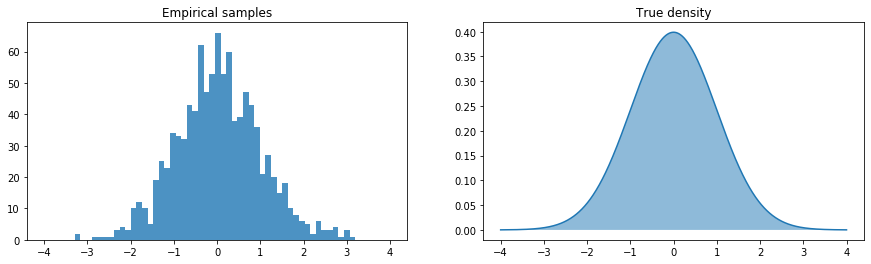

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 4))
ax1.hist(samples, 50, alpha=0.8);
ax1.set_title('Empirical samples');
ax2.plot(x, density); ax2.fill_between(x, density, 0, alpha=0.5)
ax2.set_title('True density');

- In order to transform a probability distribution, we can perform a change of variable.
- We need to scale our transformed density so that the total probability still sums to one. This is directly measured with the determinant of our transform. 
- For example, we first define $\mathbf{z}\sim q_0(\mathbf{z})=\mathcal{N}(0, 1)$, and apply the transform $\mathbf{z}'=exp(\mathbf{z})$ so that $\mathbf{z}'\sim q_1(\mathbf{z}')$

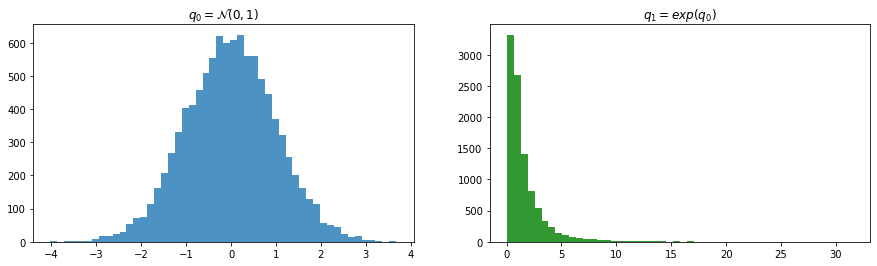

In [7]:
q0 = distrib.Normal(0, 1)
exp_t = transform.ExpTransform()
q1 = distrib.TransformedDistribution(base_distribution=q0, transforms=exp_t)

samples_q0 = q0.sample((int(1e4),))
samples_q1 = q1.sample((int(1e4),))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
ax1.hist(samples_q0, 50, alpha=0.8);
ax1.set_title('$q_0 = \mathcal{N}(0,1)$');
ax2.hist(samples_q1, 50, alpha=0.8, color='g');
ax2.set_title('$q_1=exp(q_0)$');

- q0 and q1 are defined as Distribution, we can calculate the true density function as well.

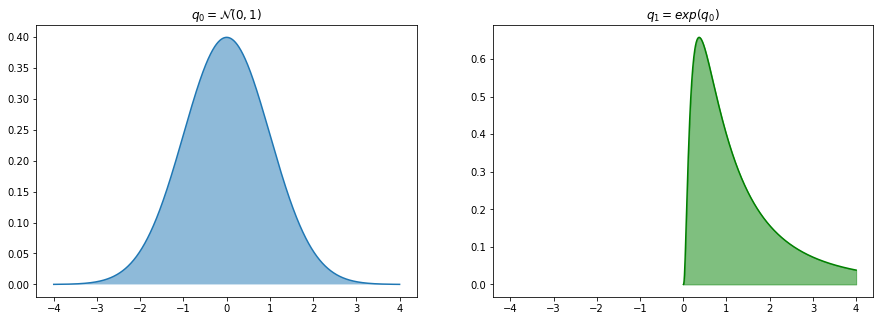

In [8]:
q0_density = torch.exp(q0.log_prob(torch.Tensor(x))).numpy()
q1_density = torch.exp(q1.log_prob(torch.Tensor(x))).numpy()
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
ax1.plot(x, q0_density); ax1.fill_between(x, q0_density, 0, alpha=0.5)
ax1.set_title('$q_0 = \mathcal{N}(0,1)$');
ax2.plot(x, q1_density, color='g'); ax2.fill_between(x, q1_density, 0, alpha=0.5, color='g')
ax2.set_title('$q_1=exp(q_0)$');

#### Chaining transforms (normalizing flows)

- To be of practical use, however, we can consider only transformations whose determinants of Jacobians are easy to compute. Of course, we can perform any amount of combined transformations.
- Let's transform a MultivariateNormal sequentially with an ExpTransform and AffineTransform.

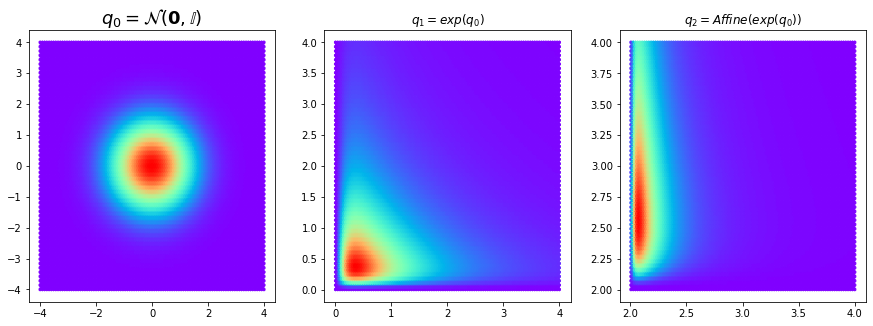

In [9]:
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))

f1 = transform.ExpTransform()
f2 = transform.AffineTransform(loc=2, scale=torch.Tensor([0.2, 1.5])) # y = scale*x + loc

q1 = distrib.TransformedDistribution(base_distribution=q0, transforms=f1)
q2 = distrib.TransformedDistribution(base_distribution=q0, transforms=[f1, f2])

# Plot all these lads
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$', fontsize=18);
ax2.hexbin(z[:,0], z[:,1], C=torch.exp(q1.log_prob(torch.Tensor(z))), cmap='rainbow')
ax2.set_title('$q_1=exp(q_0)$');
ax3.hexbin(z[:,0], z[:,1], C=torch.exp(q2.log_prob(torch.Tensor(z))), cmap='rainbow')
ax3.set_title('$q_2=Affine(exp(q_0))$');

#### Normalizing flows

- Now, we are interested in normalizing flows as we could define our own flows. And, most importantly, we could optimize the parameters of these flow in order to fit complex and richer probability distributions.

##### Planar flow

A planar normalizing flow is defined as a function of the form

$$
   f(\mathbf{z})=\mathbf{z}+\mathbf{u}h(\mathbf{w}^T\mathbf{z}+b)   
   $$

where $\mathbf{u}\in\mathbb{R}^D$ and $\mathbf{w}\in\mathbb{R}^D$ are vectors (called here scale and weight), $b\in\mathbb{R}$ is a scalar (bias) and $h$ is an activation function. These transform functions are chosen depending on the fact that

the determinant of their Jacobian can be computed in linear time
the transformation is invertible (under usually mild conditions only)
- Note that here the non-linear activation function $h$ is selected as a $tanh$. Therefore the derivative $h'$ is $1-tanh(x)^2$

In [10]:
class PlanarFlow(transform.Transform):

    def __init__(self, weight, scale, bias):
        super(PlanarFlow, self).__init__()
        self.bijective = False
        self.weight = weight
        self.scale = scale
        self.bias = bias

    def _call(self, z):
        f_z = F.linear(input=z, weight=self.weight, bias=self.bias) # f(z) = weight*z + bias
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-7)

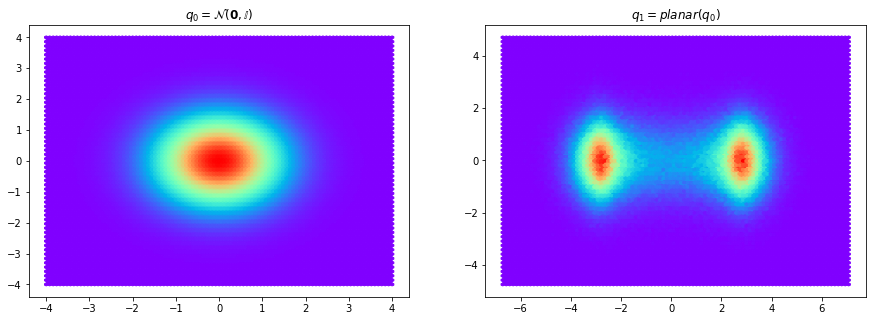

In [11]:
w = torch.Tensor([[3., 0]])
u = torch.Tensor([[2, 0]])
b = torch.Tensor([0])
q0 = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow_0 = PlanarFlow(w, u, b)

q1 = distrib.TransformedDistribution(base_distribution=q0, transforms=flow_0)
q1_samples = q1.sample((int(1e6), ))

# Plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hexbin(z[:,0], z[:,1], C=torch.exp(q0.log_prob(torch.Tensor(z))), cmap='rainbow')
ax1.set_title('$q_0 = \mathcal{N}(\mathbf{0},\mathbb{I})$');
ax2.hexbin(q1_samples[:,0], q1_samples[:,1], cmap='rainbow')
ax2.set_title('$q_1=planar(q_0)$');

#### Optimizing normalizing flows

- Now, we have to deal with the fact that the Transform object is not inherently parametric and cannot yet be optimized similarly to other modules.
- To do so, we will start by defining our own Flow class which can be seen both as a Transform and also a Modulethat can be optmized.

In [12]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

- Thanks to this little trick, we can use the same PlanarFlow class as before, that we put back here just to show that the only change is that it now inherits from the Flow class.

In [13]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

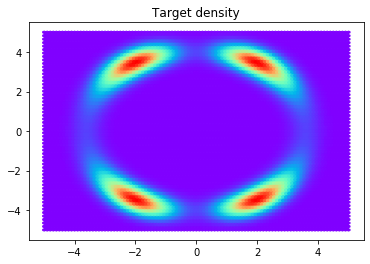

In [14]:
# Target distribution

def density_ring(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

# Plot it
x = np.linspace(-5, 5, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density');

In [15]:
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            biject.append(PlanarFlow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det

In [16]:
# Create normalizing flow
flow = NormalizingFlow(dim=2, flow_length=16, \
                       density=distrib.MultivariateNormal(torch.zeros(2), torch.eye(2)))

In [17]:
import torch.optim as optim

optimizer = optim.Adam(flow.parameters(), lr=2e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)

def loss(density, zk, log_jacobians):
    sum_of_log_jacobians = sum(log_jacobians)
    return (-sum_of_log_jacobians - torch.log(density(zk) + 1e-9)).mean()

Loss (it. 0) : 18.658895
Loss (it. 1000) : 2.357905
Loss (it. 2000) : 1.266511
Loss (it. 3000) : 1.175195
Loss (it. 4000) : 0.741253
Loss (it. 5000) : 0.682902
Loss (it. 6000) : 0.659387
Loss (it. 7000) : 0.572506
Loss (it. 8000) : 0.622327
Loss (it. 9000) : 0.598701
Loss (it. 10000) : 0.690136


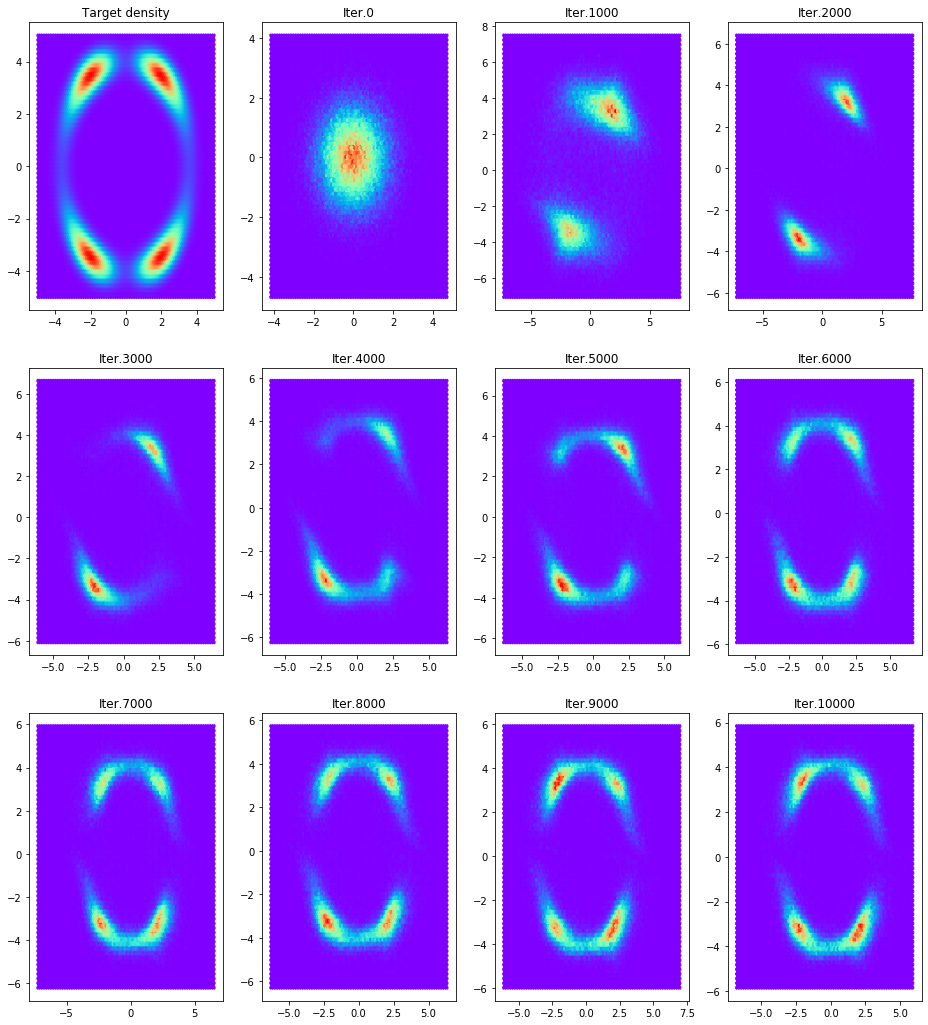

In [18]:
ref_distrib = distrib.MultivariateNormal(torch.zeros(2), torch.eye(2))
id_figure=2
plt.figure(figsize=(16, 18))
plt.subplot(3,4,1)
plt.hexbin(z[:,0], z[:,1], C=density_ring(torch.Tensor(z)).numpy().squeeze(), cmap='rainbow')
plt.title('Target density');
# Main optimization loop
for it in range(10001):
    # Draw a sample batch from Normal
    samples = ref_distrib.sample((512, ))
    # Evaluate flow of transforms
    zk, log_jacobians = flow(samples)
    # Evaluate loss and backprop
    optimizer.zero_grad()
    loss_v = loss(density_ring, zk, log_jacobians)
    loss_v.backward()
    optimizer.step()
    scheduler.step()
    if (it % 1000 == 0):
        print('Loss (it. %i) : %f'%(it, loss_v.item()))
        # Draw random samples
        samples = ref_distrib.sample((int(1e5), ))
        # Evaluate flow and plot
        zk, _ = flow(samples)
        zk = zk.detach().numpy()
        plt.subplot(3,4,id_figure)
        plt.hexbin(zk[:,0], zk[:,1], cmap='rainbow')
        plt.title('Iter.%i'%(it));
        id_figure += 1